In [1]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 52.44 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [2]:
!git clone https://github.com/wutianyiRosun/CGNet.git

Cloning into 'CGNet'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 292 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (292/292), 1.99 MiB | 12.25 MiB/s, done.
Resolving deltas: 100% (112/112), done.


2024-04-25 11:29:07.837492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 11:29:07.837644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 11:29:08.098537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['cgnet-camvid-output']


(360, 480, 3)

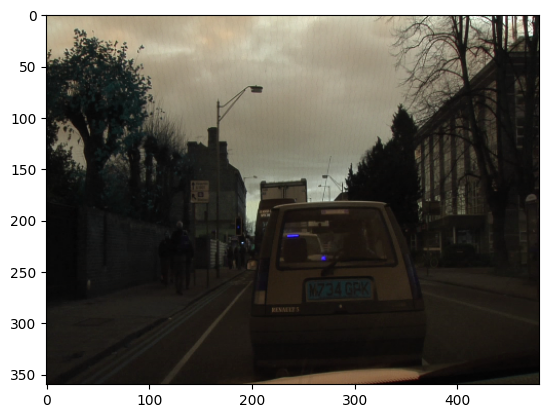

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import os
print(os.listdir("../input"))
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice

temp_img = cv2.imread("/kaggle/input/cgnet-camvid-output/CAMVID_data/test/0001TP_009420.png") #3 channels / spectral bands
plt.imshow(temp_img)
temp_img.shape

In [5]:
import torch
import os
import os.path as osp
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import torchvision
import cv2
from torch.utils import data
import pickle
from PIL import Image

import os
import shutil

def copy_subfolders(source_folders, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate over each source folder
    for source_folder in source_folders:
        # Get the list of sub-folders in the source folder
        subfolders = [f.path for f in os.scandir(source_folder) if f.is_dir()]
        
        # Iterate over each sub-folder and copy it to the destination folder
        for subfolder in subfolders:
            subfolder_name = os.path.basename(subfolder)
            destination_subfolder = os.path.join(destination_folder, subfolder_name)
            
            # Copy the sub-folder to the destination folder
            shutil.copytree(subfolder, destination_subfolder)
            print(f"Sub-folder '{subfolder_name}' copied to '{destination_folder}'")

# Source folders to copy sub-folders from
source_folders = [
    '/kaggle/working/SegNet-Tutorial/CamVid',
    '/kaggle/working/CGNet/dataset/list/CamVid'
]

# Destination folder to add the copied sub-folders
destination_folder = '/kaggle/working/CAMVID_data'

# Call the function to copy sub-folders
copy_subfolders(source_folders, destination_folder)


Sub-folder 'valannot' copied to '/kaggle/working/CAMVID_data'
Sub-folder 'val' copied to '/kaggle/working/CAMVID_data'
Sub-folder 'train' copied to '/kaggle/working/CAMVID_data'
Sub-folder 'testannot' copied to '/kaggle/working/CAMVID_data'
Sub-folder 'trainannot' copied to '/kaggle/working/CAMVID_data'
Sub-folder 'test' copied to '/kaggle/working/CAMVID_data'


In [6]:
def copy_txt_files(source_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get the list of files in the source folder
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

    # Iterate over each file and copy it if it has a .txt extension
    for file in files:
        if file.endswith('.txt'):
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join(destination_folder, file)
            shutil.copyfile(source_file, destination_file)
            print(f"File '{file}' copied to '{destination_folder}'")

# Source folder containing .txt files
source_folder = '/kaggle/working/CGNet/dataset/list/CamVid'

# Destination folder to copy .txt files
dest_folder = '/kaggle/working/CAMVID_data'

# Call the function to copy .txt files
copy_txt_files(source_folder, dest_folder)

File 'camvid_val_list.txt' copied to '/kaggle/working/CAMVID_data'
File 'camvid_test_list.txt' copied to '/kaggle/working/CAMVID_data'
File 'camvid_train_list.txt' copied to '/kaggle/working/CAMVID_data'
File 'camvid_trainval_list.txt' copied to '/kaggle/working/CAMVID_data'


In [7]:
# %cd /kaggle/working/CGNet
%cd /kaggle/input/cgnet-camvid-output/CGNet

/kaggle/input/cgnet-camvid-output/CGNet


In [8]:
class CamVidDataSet(data.Dataset):
    """ 
       CamVidDataSet is employed to load train set
       Args:
        root: the CamVid dataset path, 
        list_path: camvid_train_list.txt, include partial path

    """
    def __init__(self, root= '/kaggle/working/CAMVID_data', list_path='/kaggle/working/CAMVID_data/camvid_train_list.txt', max_iters=None, crop_size=(360, 360), 
            mean=(128, 128, 128), scale=True, mirror=True, ignore_label=11 ):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.scale = scale
        self.ignore_label = ignore_label
        self.mean = mean
        self.is_mirror = mirror
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        if not max_iters==None:
            self.img_ids = self.img_ids * int(np.ceil(float(max_iters) / len(self.img_ids)))
        self.files = []


        # for split in ["train", "trainval", "val"]:
        for name in self.img_ids:
            img_file = osp.join(self.root, name.split()[0])
            #print(img_file)
            label_file = osp.join(self.root, name.split()[1])
            #print(label_file)
            self.files.append({
                "img": img_file,
                "label": label_file,
                "name": name
            })

        print("length of train set: ",len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        label = cv2.imread(datafiles["label"], cv2.IMREAD_GRAYSCALE)
        size = image.shape
        name = datafiles["name"]
        if self.scale:
            f_scale = 0.5 + random.randint(0, 15) / 10.0  #random resize between 0.5 and 2 
            image = cv2.resize(image, None, fx=f_scale, fy=f_scale, interpolation = cv2.INTER_LINEAR)
            label = cv2.resize(label, None, fx=f_scale, fy=f_scale, interpolation = cv2.INTER_NEAREST)

        image = np.asarray(image, np.float32)
        
        image = image[:, :, ::-1]  # change to BGR
        image -= self.mean
        img_h, img_w = label.shape
        pad_h = max(self.crop_h - img_h, 0)
        pad_w = max(self.crop_w - img_w, 0)
        if pad_h > 0 or pad_w > 0:
            img_pad = cv2.copyMakeBorder(image, 0, pad_h, 0, 
                pad_w, cv2.BORDER_CONSTANT, 
                value=(0.0, 0.0, 0.0))
            label_pad = cv2.copyMakeBorder(label, 0, pad_h, 0, 
                pad_w, cv2.BORDER_CONSTANT,
                value=(self.ignore_label,))
        else:
            img_pad, label_pad = image, label

        img_h, img_w = label_pad.shape
        h_off = random.randint(0, img_h - self.crop_h)
        w_off = random.randint(0, img_w - self.crop_w)
        # roi = cv2.Rect(w_off, h_off, self.crop_w, self.crop_h);
        image = np.asarray(img_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        label = np.asarray(label_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        
        
        image = image.transpose((2, 0, 1)) # NHWC -> NCHW
        
        if self.is_mirror:
            flip = np.random.choice(2) * 2 - 1
            image = image[:, :, ::flip]
            label = label[:, ::flip]


        return image.copy(), label.copy(), np.array(size), name

In [9]:
class CamVidValDataSet(data.Dataset):
    """ 
       CamVidValDataSet is employed to load val set
       Args:
        root: the CamVid dataset path, 
        list_path: camvid_val_list.txt, include partial path

    """
    def __init__(self, root= '/kaggle/working/CAMVID_data', list_path='/kaggle/working/CAMVID_data/camvid_val_list.txt', f_scale=1, mean=(128, 128, 128), ignore_label=11):
        self.root = root
        self.list_path = list_path
        self.ignore_label = ignore_label
        self.mean = mean
        self.f_scale = f_scale
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []
        for name in self.img_ids:
            img_file = osp.join(self.root, name.split()[0])
            #print(img_file)
            label_file = osp.join(self.root, name.split()[1])
            #print(label_file)
            image_name = name.strip().split()[0].strip().split('/',1)[1].split('.')[0]
            #print("image_name:  ",image_name)
            self.files.append({
                "img": img_file,
                "label": label_file,
                "name": image_name
            })

        print("length of Validation set: ",len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        label = cv2.imread(datafiles["label"], cv2.IMREAD_GRAYSCALE)
        size = image.shape
        name = datafiles["name"]
        if self.f_scale!=1:
            image = cv2.resize(image, None, fx=self.f_scale, fy=self.f_scale, interpolation = cv2.INTER_LINEAR)
            #label = cv2.resize(label, None, fx=self.f_scale, fy=self.f_scale, interpolation = cv2.INTER_NEAREST)

        image = np.asarray(image, np.float32)

        image = image[:, :, ::-1]  # change to BGR
        image -= self.mean
        image = image.transpose((2, 0, 1)) # HWC -> CHW
        
        #print('image.shape:',image.shape)
        return image.copy(), label.copy(), np.array(size), name

In [10]:
class CamVidTestDataSet(data.Dataset):
    """ 
       CamVidTestDataSet is employed to load test set
       Args:
        root: the CamVid dataset path, 
        list_path: camvid_test_list.txt, include partial path

    """
    def __init__(self, root= '/kaggle/working/CAMVID_data', list_path='/kaggle/working/CAMVID_data/camvid_test_list.txt', mean=(128, 128, 128), ignore_label=11):
        self.root = root
        self.list_path = list_path
        self.ignore_label = ignore_label
        self.mean = mean
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []
        for name in self.img_ids:

            img_file = osp.join(self.root, name.split()[0])
            print(img_file)
            image_name = name.strip().split()[0].strip().split('/',3)[3].split('.')[0]
            print(image_name)
            self.files.append({
                "img": img_file,
                "name": image_name
            })
        print("lenth of test set ", len(self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]

        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        name = datafiles["name"]

      

        image = np.asarray(image, np.float32)

        size = image.shape
        image = image[:, :, ::-1]  # change to BGR
        image -= self.mean
        image = image.transpose((2, 0, 1)) # HWC -> CHW

        return image.copy(), np.array(size), name


In [11]:
class CamVidTrainInform:
    """ To get statistical information about the train set, such as mean, std, class distribution.
        The class is employed for tackle class imbalance.
    """
    def __init__(self, data_dir= '/kaggle/working/CAMVID_data', classes= 11, train_set_file='camvid_trainval_list.txt', inform_data_file="camvid_inform.pkl", normVal=1.10):
        """
        Args:
           data_dir: directory where the dataset is kept
           classes: number of classes in the dataset
           inform_data_file: location where cached file has to be stored
           normVal: normalization value, as defined in ERFNet paper
        """
        self.data_dir = data_dir
        self.classes = classes
        self.classWeights = np.ones(self.classes, dtype=np.float32)
        self.normVal = normVal
        self.mean = np.zeros(3, dtype=np.float32)
        self.std = np.zeros(3, dtype=np.float32)
        self.train_set_file= train_set_file
        self.inform_data_file = inform_data_file

    def compute_class_weights(self, histogram):
        """to compute the class weights
        Args:
            histogram: distribution of class samples
        """
        normHist = histogram / np.sum(histogram)
        for i in range(self.classes):
            self.classWeights[i] = 1 / (np.log(self.normVal + normHist[i]))

    def readWholeTrainSet(self, fileName , train_flag=True):
        """to read the whole train set of current dataset.
        Args:
        fileName: train set file that stores the image locations
        trainStg: if processing training or validation data
        
        return: 0 if successful
        """
        global_hist = np.zeros(self.classes, dtype=np.float32)

        no_files = 0
        min_val_al = 0
        max_val_al = 0
        print('Labels can take value between 0 and number of classes.')
        with open(self.data_dir + '/' + fileName, 'r') as textFile:
        #with open(fileName, 'r') as textFile:
            for line in textFile:
                # we expect the text file to contain the data in following format
                # <RGB Image> <Label Image>
                line_arr = line.split()
                img_file = ((self.data_dir).strip() + '/' + line_arr[0].strip()).strip()
                label_file = ((self.data_dir).strip() + '/' + line_arr[1].strip()).strip()

                label_img = cv2.imread(label_file, 0)
                unique_values = np.unique(label_img)
                max_val = max(unique_values)
                min_val = min(unique_values)

                max_val_al = max(max_val, max_val_al)
                min_val_al = min(min_val, min_val_al)

                if train_flag == True:
                    hist = np.histogram(label_img, self.classes, [0, self.classes-1])
                    global_hist += hist[0]

                    rgb_img = cv2.imread(img_file)
                    self.mean[0] += np.mean(rgb_img[:,:,0])
                    self.mean[1] += np.mean(rgb_img[:, :, 1])
                    self.mean[2] += np.mean(rgb_img[:, :, 2])

                    self.std[0] += np.std(rgb_img[:, :, 0])
                    self.std[1] += np.std(rgb_img[:, :, 1])
                    self.std[2] += np.std(rgb_img[:, :, 2])

                else:
                    print("we can only collect statistical information of train set, please check")

                if max_val > (self.classes - 1) or min_val < 0:
#                     print('Labels can take value between 0 and number of classes.')
                    print('Some problem with labels. Please check. label_set:',unique_values)
                    print('Label Image ID: ' + label_file)
                no_files += 1

        # divide the mean and std values by the sample space size
        self.mean /= no_files
        self.std /= no_files

        #compute the class imbalance information
        self.compute_class_weights(global_hist)
        return 0

    def collectDataAndSave(self):
        """ To collect statistical information of train set and then save it.
        The file train.txt should be inside the data directory.
        """
        print('Processing training data')
        return_val = self.readWholeTrainSet(fileName= self.train_set_file)

        print('Pickling data')
        if return_val ==0 :
            data_dict = dict()
            data_dict['mean'] = self.mean
            data_dict['std'] = self.std
            data_dict['classWeights'] = self.classWeights
            pickle.dump(data_dict, open(self.inform_data_file, "wb"))
            return data_dict
        return None

In [12]:
import os
import time
import torch
import timeit
import pickle
import random
import numpy as np
import torch.nn as nn
from torch.utils import data
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from argparse import ArgumentParser
#user
from model import CGNet  # network
from utils.metric import get_iou
from utils.modeltools import netParams
from utils.loss import CrossEntropyLoss2d  # loss function
from utils.convert_state import convert_state_dict

In [13]:
def val(args, val_loader, model, criterion):
    """
    args:
      val_loader: loaded for validation dataset
      model: model
      criterion: loss function
    return: IoU class, and mean IoU
    """
    #evaluation mode
    model.eval()
    total_batches = len(val_loader)
   
    data_list=[]
    for i, (input, label, size, name) in enumerate(val_loader):
        start_time = time.time()
        input_var = Variable(input, volatile=True).cuda()
        output = model(input_var)
        time_taken = time.time() - start_time
#         print("[%d/%d]  time: %.2f" % (i, total_batches, time_taken))
        output= output.cpu().data[0].numpy()
        gt = np.asarray(label[0].numpy(), dtype = np.uint8)
        output= output.transpose(1,2,0)
        output= np.asarray(np.argmax(output, axis=2), dtype=np.uint8)
        data_list.append( [gt.flatten(), output.flatten()])

    meanIoU, per_class_iu= get_iou(data_list, args.classes)
    return meanIoU, per_class_iu

In [14]:
def adjust_learning_rate( args, cur_epoch, max_epoch, curEpoch_iter, perEpoch_iter, baselr):
    """
    poly learning stategyt
    lr = baselr*(1-iter/max_iter)^power
    """
    cur_iter = cur_epoch*perEpoch_iter + curEpoch_iter
    max_iter=max_epoch*perEpoch_iter
    lr = baselr*pow( (1 - 1.0*cur_iter/max_iter), 0.9)

    return lr

In [15]:
import tqdm
import time
def train(args, train_loader, model, criterion, optimizer, epoch):
    """
    args:
       train_loader: loaded for training dataset
       model: model
       criterion: loss function
       optimizer: optimization algorithm, such as ADAM or SGD
       epoch: epoch number
    return: average loss, per class IoU, and mean IoU
    """
    model.train()
    epoch_loss = []

    data_list=[]
    total_batches = len(train_loader)
    print("=====> the number of iterations per epoch: ", total_batches)
    for iteration, batch in enumerate( train_loader, 0 ):
        lr= adjust_learning_rate( args, cur_epoch = epoch, max_epoch = args.max_epochs, 
                                  curEpoch_iter = iteration, perEpoch_iter = total_batches, baselr = args.lr )
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr;
        
        start_time = time.time()
        images, labels, _, _ = batch
        images = Variable( images ).cuda()
        labels = Variable( labels.long() ).cuda()
        output = model( images )
        loss = criterion(output, labels)
        optimizer.zero_grad()  #set the grad to zero
        loss.backward()
        optimizer.step()
        epoch_loss.append( loss.item() )
        time_taken = time.time() - start_time
        
        gt = np.asarray( labels.cpu().data[0].numpy(), dtype = np.uint8 )
        output = output.cpu().data[0].numpy()
        output = output.transpose(1,2,0)
        output = np.asarray( np.argmax(output, axis=2), dtype=np.uint8 )

        data_list.append( [gt.flatten(), output.flatten()] )
        

#         print('=====> epoch[%d/%d] iter: (%d/%d) \tcur_lr: %.6f loss: %.3f time:%.2f' % ( epoch, args.max_epochs,
#               iteration, total_batches, lr,loss.item(), time_taken ) )

    for i in tqdm.tqdm(range(58)):
        time.sleep(0.01)
    average_epoch_loss_train = sum( epoch_loss ) / len( epoch_loss )
    meanIoU, per_class_iu = get_iou( data_list, args.classes )

    return average_epoch_loss_train, per_class_iu, meanIoU, lr

In [16]:
def train_model(args):
    """
    args:
       args: global arguments
    """
    h, w = map(int, args.input_size.split(','))
    input_size = (h, w)
    print("=====> checking if inform_data_file exists")
    if not os.path.isfile(args.inform_data_file):
        print("%s is not found" %( args.inform_data_file ) )
        dataCollect = CamVidTrainInform(args.data_dir, args.classes, train_set_file = args.dataset_list, 
                                        inform_data_file = args.inform_data_file) #collect mean std, weigth_class information
        datas = dataCollect.collectDataAndSave()
        if datas is None:
            print("error while pickling data. Please check.")
            exit(-1)
    else:
        print("find file: ", str(args.inform_data_file))
        datas = pickle.load( open( args.inform_data_file, "rb") )
    
    print(args)
    global network_type
     
    if args.cuda:
        print("=====> use gpu id: '{}'".format(args.gpus))
        os.environ["CUDA_VISIBLE_DEVICES"] = args.gpus
        if not torch.cuda.is_available():
            raise Exception("No GPU found or Wrong gpu id, please run without --cuda")
    
    args.seed = random.randint(1, 10000)
    print("====> Random Seed: ", args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed) 
    
    cudnn.enabled = True
    M = args.M
    N = args.N
    print("=====> building network")
    model = CGNet.Context_Guided_Network(classes= args.classes, M= M, N= N)
    network_type="CGNet"
    print("=====> current architeture:  CGNet")
    
    print("=====> computing network parameters")
    total_paramters = netParams(model)
    print("the number of parameters: " + str(total_paramters))
    
    print("data['classWeights']: ", datas['classWeights'])
    print('=====> Dataset statistics')
    print('mean and std: ', datas['mean'], datas['std'])
    
    # define optimization criteria
    weight = torch.from_numpy(datas['classWeights'])
    criteria = CrossEntropyLoss2d(weight, args.ignore_label)

    if args.cuda:
        criteria = criteria.cuda()
        args.gpu_nums = 1
        if torch.cuda.device_count()>1:
            print("torch.cuda.device_count()=",torch.cuda.device_count())
            args.gpu_nums = torch.cuda.device_count()
            model = torch.nn.DataParallel(model).cuda()
        else:
            print("single GPU for training")
            model = model.cuda()  
    
    args.savedir = ( args.savedir + args.dataset + '/'+ network_type +"_M"+ str(M) + 'N' +str(N) + 'bs' 
                    + str(args.batch_size)+ 'gpu' + str(args.gpu_nums)+ "_"+str(args.train_type)+'/')
    if not os.path.exists(args.savedir):
        os.makedirs(args.savedir)

    #Data augmentation, compose the data with transforms
    train_transform= transforms.Compose([
        transforms.ToTensor()])
    trainLoader = data.DataLoader( CamVidDataSet( args.data_dir, args.train_data_list, crop_size = input_size, scale = args.random_scale, 
                                                      mirror = args.random_mirror, mean = datas['mean'] ),
                                   batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers, 
                                   pin_memory = True, drop_last = True )
    valLoader = data.DataLoader( CamVidValDataSet( args.data_dir, args.val_data_list,f_scale = 1,  mean = datas['mean']),
                                 batch_size = 1, shuffle = True, num_workers = args.num_workers, pin_memory = True, drop_last = True )

    start_epoch = 0
    if args.resume:
        if os.path.isfile(args.resume):
            checkpoint = torch.load(args.resume)
            start_epoch = checkpoint['epoch']
            model.load_state_dict(checkpoint['model'])
            #model.load_state_dict(convert_state_dict(checkpoint['model']))
            print("=====> loading checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
        else:
            print("=====> no checkpoint found at '{}'".format(args.resume))
    
    model.train()
    cudnn.benchmark= True
    
    logFileLoc = args.savedir + args.logFile
    if os.path.isfile(logFileLoc):
        logger = open(logFileLoc, 'a')
    else:
        logger = open(logFileLoc, 'w')
        logger.write("Parameters: %s" % (str(total_paramters)))
        logger.write("\n%s\t\t%s\t\t%s\t\t%s\t\t%s\t\t" % ('Epoch', 'Loss(Tr)', 'Loss(val)', 'mIOU (tr)', 'mIOU (val)'))
    logger.flush()

    optimizer = torch.optim.Adam(model.parameters(), args.lr, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)
 
    print('=====> beginning training')
    for epoch in range(start_epoch, args.max_epochs):
        #training
        lossTr, per_class_iu_tr, mIOU_tr, lr = train(args, trainLoader, model, criteria, optimizer, epoch)
        
        #validation
        if epoch % 1 ==0:
            mIOU_val, per_class_iu = val(args, valLoader, model, criteria)
            logger.write("\n%d\t\t%.4f\t\t%.4f\t\t%.4f\t\t%.7f" % (epoch, lossTr, mIOU_tr, mIOU_val, lr))
            logger.flush()
            print("epoch: " + str(epoch) + ' Details')
            print("\nEpoch No.: %d\tTrain Loss = %.4f\t mIOU(tr) = %.4f\t mIOU(val) = %.4f\t lr= %.6f" % (epoch,
                   lossTr, mIOU_tr, mIOU_val, lr))
        else:
            logger.write("\n%d\t\t%.4f\t\t%.4f\t\t%.7f" % (epoch, lossTr, mIOU_tr, lr))
            logger.flush()
            print("Epoch : " + str(epoch) + ' Details')
            print("\nEpoch No.: %d\tTrain Loss = %.4f\t mIOU(tr) = %.4f\t lr= %.6f" % (epoch, lossTr, mIOU_tr, lr))
        
        #save the model
        model_file_name = args.savedir +'/model_' + str(epoch + 1) + '.pth'
        state = {"epoch": epoch+1, "model": model.state_dict()}
        if epoch > args.max_epochs - 10:
            torch.save(state, model_file_name)
        elif not epoch % 20:
            torch.save(state, model_file_name)

    logger.close()

In [17]:
import sys
import argparse

# Create ArgumentParser object and define arguments
parser = argparse.ArgumentParser()
parser.add_argument('--model', default="CGNet", help="model name: Context Guided Network (CGNet)")
# Add other argument definitions...

# Parse only arguments that are passed as command-line arguments
args, unknown = parser.parse_known_args(sys.argv)

# Now you can access parsed arguments using 'args'
print(args)

Namespace(model='CGNet')


In [18]:
import os

def add_folder(parent_folder, new_folder_name):
    # Construct the path for the new folder
    new_folder_path = os.path.join(parent_folder, new_folder_name)

    # Check if the folder already exists
    if not os.path.exists(new_folder_path):
        # Create the new folder
        os.makedirs(new_folder_path)
        print(f"Folder '{new_folder_name}' added successfully to '{parent_folder}'.")
    else:
        print(f"Folder '{new_folder_name}' already exists in '{parent_folder}'.")

# Example usage:
parent_folder = "/kaggle/working/CGNet/checkpoint/camvid"  # Replace this with the path of the parent folder
new_folder_name = "CGNet_M3N9bs8gpu1_ontrainval"  # Replace this with the name of the new folder

add_folder(parent_folder, new_folder_name)


Folder 'CGNet_M3N9bs8gpu1_ontrainval' added successfully to '/kaggle/working/CGNet/checkpoint/camvid'.


In [19]:
import sys
import argparse
if __name__ == '__main__':
#     parser = ArgumentParser()
    # Create ArgumentParser object and define arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--model', default = "CGNet", help = "model name: Context Guided Network (CGNet)")
    parser.add_argument('--dataset', default = "camvid", help = "dataset: cityscapes or camvid")
    parser.add_argument('--ignore_label', type = int,  default = 11, help = "nClass")
    parser.add_argument('--data_dir', default = "/kaggle/working/CAMVID_data", help ='data directory')
    parser.add_argument('--dataset_list', default = "camvid_trainval_list.txt",
                    help = "train and val data, for computing the ration of all kinds, mean and std")

    parser.add_argument('--train_data_list', default = "/kaggle/working/CAMVID_data/camvid_trainval_list.txt", help = "train set")
    parser.add_argument('--train_type', type = str, default = "ontrainval", 
                         help = "ontrain for training on train set, ontrainval for training on train+val set")

    parser.add_argument('--max_epochs', type = int, default = 70, help = "the number of epochs: 70 for train+val set")
    parser.add_argument('--val_data_list', default = "/kaggle/working/CAMVID_data/camvid_val_list.txt", help = "val set")
    parser.add_argument('--scaleIn', type = int, default = 1, help = "for input image, default is 1, keep fixed size")  
    parser.add_argument('--input_size', type = str, default = "360,360", help = "input size of model") 
    parser.add_argument('--random_mirror', type = bool, default = True, help = "input image random mirror") 
    parser.add_argument('--random_scale', type = bool, default = True, help = "input image resize 0.5 to 2") 
    parser.add_argument('--num_workers', type = int, default = 1, help = " the number of parallel threads") 
    parser.add_argument('--batch_size', type = int, default = 8, help = "the batch size is set to 16 for 2 GPUs")
    parser.add_argument('--lr', type = float, default = 1e-3, help = "initial learning rate")
    parser.add_argument('--savedir', default = "./checkpoint/", help = "directory to save the model snapshot")
    parser.add_argument('--resume', type = str, default = "./checkpoint/camvid/CGNet_M3N21bs8gpu1_ontrainval/model_1.pth", 
                    help = "use this file to load last checkpoint for continuing training")  
    parser.add_argument('--classes', type = int, default = 11, 
                    help = "the number of classes in the dataset. 19 and 11 for cityscapes and camvid, respectively")
    parser.add_argument('--inform_data_file', default = "/kaggle/input/cgnet-camvid-output/CGNet/camvid_inform.pkl", 
                    help = "saving statistic information of the dataset (train+val set), classes weigtht, mean and std")
    parser.add_argument('--M', type = int, default = 3, help = "the number of blocks in stage 2")
    parser.add_argument('--N', type = int, default = 9, help = "the number of blocks in stage 3")
    parser.add_argument('--logFile', default= "log.txt", help = "storing the training and validation logs")
    parser.add_argument('--cuda', type = bool, default = True, help = "running on CPU or GPU")
    parser.add_argument('--gpus', type = str, default = "0", help = "default GPU devices (0)")
#     args = parser.parse_args()
    # Parse only arguments that are passed as command-line arguments
    args, unknown = parser.parse_known_args(sys.argv)
print(args)

Namespace(model='CGNet', dataset='camvid', ignore_label=11, data_dir='/kaggle/working/CAMVID_data', dataset_list='camvid_trainval_list.txt', train_data_list='/kaggle/working/CAMVID_data/camvid_trainval_list.txt', train_type='ontrainval', max_epochs=70, val_data_list='/kaggle/working/CAMVID_data/camvid_val_list.txt', scaleIn=1, input_size='360,360', random_mirror=True, random_scale=True, num_workers=1, batch_size=8, lr=0.001, savedir='./checkpoint/', resume='./checkpoint/camvid/CGNet_M3N21bs8gpu1_ontrainval/model_1.pth', classes=11, inform_data_file='/kaggle/input/cgnet-camvid-output/CGNet/camvid_inform.pkl', M=3, N=9, logFile='log.txt', cuda=True, gpus='0')


In [20]:
%cd /kaggle/working/CGNet

/kaggle/working/CGNet


In [21]:
train_model(args)

=====> checking if inform_data_file exists
find file:  /kaggle/input/cgnet-camvid-output/CGNet/camvid_inform.pkl
Namespace(model='CGNet', dataset='camvid', ignore_label=11, data_dir='/kaggle/working/CAMVID_data', dataset_list='camvid_trainval_list.txt', train_data_list='/kaggle/working/CAMVID_data/camvid_trainval_list.txt', train_type='ontrainval', max_epochs=70, val_data_list='/kaggle/working/CAMVID_data/camvid_val_list.txt', scaleIn=1, input_size='360,360', random_mirror=True, random_scale=True, num_workers=1, batch_size=8, lr=0.001, savedir='./checkpoint/', resume='./checkpoint/camvid/CGNet_M3N21bs8gpu1_ontrainval/model_1.pth', classes=11, inform_data_file='/kaggle/input/cgnet-camvid-output/CGNet/camvid_inform.pkl', M=3, N=9, logFile='log.txt', cuda=True, gpus='0')
=====> use gpu id: '0'
====> Random Seed:  8296
=====> building network
=====> current architeture:  CGNet
=====> computing network parameters
the number of params: 0.35 M
the number of parameters: 349010
data['classWeigh

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 58/58 [00:00<00:00, 98.10it/s]
/tmp/ipykernel_34/1738558686.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = Variable(input, volatile=True).cuda()


epoch: 0 Details

Epoch No.: 0	Train Loss = 1.2524	 mIOU(tr) = 0.2602	 mIOU(val) = 0.4470	 lr= 0.000987
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.97it/s]


epoch: 1 Details

Epoch No.: 1	Train Loss = 0.8488	 mIOU(tr) = 0.3856	 mIOU(val) = 0.4090	 lr= 0.000974
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.98it/s]


epoch: 2 Details

Epoch No.: 2	Train Loss = 0.7460	 mIOU(tr) = 0.4561	 mIOU(val) = 0.5978	 lr= 0.000962
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.56it/s]


epoch: 3 Details

Epoch No.: 3	Train Loss = 0.6549	 mIOU(tr) = 0.4945	 mIOU(val) = 0.5283	 lr= 0.000949
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 96.95it/s]


epoch: 4 Details

Epoch No.: 4	Train Loss = 0.6011	 mIOU(tr) = 0.4882	 mIOU(val) = 0.5772	 lr= 0.000936
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.82it/s]


epoch: 5 Details

Epoch No.: 5	Train Loss = 0.5763	 mIOU(tr) = 0.5258	 mIOU(val) = 0.6248	 lr= 0.000923
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.86it/s]


epoch: 6 Details

Epoch No.: 6	Train Loss = 0.5379	 mIOU(tr) = 0.5391	 mIOU(val) = 0.6207	 lr= 0.000910
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.27it/s]


epoch: 7 Details

Epoch No.: 7	Train Loss = 0.4986	 mIOU(tr) = 0.5374	 mIOU(val) = 0.6232	 lr= 0.000897
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.06it/s]


epoch: 8 Details

Epoch No.: 8	Train Loss = 0.4951	 mIOU(tr) = 0.5835	 mIOU(val) = 0.6129	 lr= 0.000884
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.90it/s]


epoch: 9 Details

Epoch No.: 9	Train Loss = 0.4781	 mIOU(tr) = 0.5643	 mIOU(val) = 0.6890	 lr= 0.000871
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.93it/s]


epoch: 10 Details

Epoch No.: 10	Train Loss = 0.4698	 mIOU(tr) = 0.5709	 mIOU(val) = 0.6455	 lr= 0.000858
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.88it/s]


epoch: 11 Details

Epoch No.: 11	Train Loss = 0.4687	 mIOU(tr) = 0.5826	 mIOU(val) = 0.6725	 lr= 0.000845
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.90it/s]


epoch: 12 Details

Epoch No.: 12	Train Loss = 0.4367	 mIOU(tr) = 0.5932	 mIOU(val) = 0.6935	 lr= 0.000831
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.17it/s]


epoch: 13 Details

Epoch No.: 13	Train Loss = 0.4528	 mIOU(tr) = 0.5706	 mIOU(val) = 0.7001	 lr= 0.000818
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.40it/s]


epoch: 14 Details

Epoch No.: 14	Train Loss = 0.4136	 mIOU(tr) = 0.6121	 mIOU(val) = 0.7137	 lr= 0.000805
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.50it/s]


epoch: 15 Details

Epoch No.: 15	Train Loss = 0.4052	 mIOU(tr) = 0.6156	 mIOU(val) = 0.6805	 lr= 0.000792
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.04it/s]


epoch: 16 Details

Epoch No.: 16	Train Loss = 0.3781	 mIOU(tr) = 0.6158	 mIOU(val) = 0.7101	 lr= 0.000779
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.29it/s]


epoch: 17 Details

Epoch No.: 17	Train Loss = 0.3892	 mIOU(tr) = 0.6122	 mIOU(val) = 0.7039	 lr= 0.000765
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.97it/s]


epoch: 18 Details

Epoch No.: 18	Train Loss = 0.3949	 mIOU(tr) = 0.6195	 mIOU(val) = 0.7150	 lr= 0.000752
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.06it/s]


epoch: 19 Details

Epoch No.: 19	Train Loss = 0.3995	 mIOU(tr) = 0.6249	 mIOU(val) = 0.7173	 lr= 0.000739
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.90it/s]


epoch: 20 Details

Epoch No.: 20	Train Loss = 0.3714	 mIOU(tr) = 0.6369	 mIOU(val) = 0.7118	 lr= 0.000726
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.01it/s]


epoch: 21 Details

Epoch No.: 21	Train Loss = 0.3691	 mIOU(tr) = 0.6757	 mIOU(val) = 0.7202	 lr= 0.000712
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.00it/s]


epoch: 22 Details

Epoch No.: 22	Train Loss = 0.3578	 mIOU(tr) = 0.6277	 mIOU(val) = 0.7222	 lr= 0.000699
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.03it/s]


epoch: 23 Details

Epoch No.: 23	Train Loss = 0.3483	 mIOU(tr) = 0.6370	 mIOU(val) = 0.7333	 lr= 0.000686
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.84it/s]


epoch: 24 Details

Epoch No.: 24	Train Loss = 0.3612	 mIOU(tr) = 0.6373	 mIOU(val) = 0.7403	 lr= 0.000672
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.91it/s]


epoch: 25 Details

Epoch No.: 25	Train Loss = 0.3473	 mIOU(tr) = 0.6383	 mIOU(val) = 0.7378	 lr= 0.000659
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.97it/s]


epoch: 26 Details

Epoch No.: 26	Train Loss = 0.3541	 mIOU(tr) = 0.6440	 mIOU(val) = 0.7211	 lr= 0.000645
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.11it/s]


epoch: 27 Details

Epoch No.: 27	Train Loss = 0.3431	 mIOU(tr) = 0.6536	 mIOU(val) = 0.7239	 lr= 0.000632
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.85it/s]


epoch: 28 Details

Epoch No.: 28	Train Loss = 0.3520	 mIOU(tr) = 0.6697	 mIOU(val) = 0.7517	 lr= 0.000618
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.31it/s]


epoch: 29 Details

Epoch No.: 29	Train Loss = 0.3285	 mIOU(tr) = 0.6564	 mIOU(val) = 0.7192	 lr= 0.000605
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.23it/s]


epoch: 30 Details

Epoch No.: 30	Train Loss = 0.3279	 mIOU(tr) = 0.6439	 mIOU(val) = 0.7558	 lr= 0.000591
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.80it/s]


epoch: 31 Details

Epoch No.: 31	Train Loss = 0.3318	 mIOU(tr) = 0.6778	 mIOU(val) = 0.7261	 lr= 0.000577
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.11it/s]


epoch: 32 Details

Epoch No.: 32	Train Loss = 0.3387	 mIOU(tr) = 0.6533	 mIOU(val) = 0.7549	 lr= 0.000564
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.26it/s]


epoch: 33 Details

Epoch No.: 33	Train Loss = 0.3204	 mIOU(tr) = 0.6859	 mIOU(val) = 0.7544	 lr= 0.000550
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.64it/s]


epoch: 34 Details

Epoch No.: 34	Train Loss = 0.3053	 mIOU(tr) = 0.6803	 mIOU(val) = 0.7461	 lr= 0.000536
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.27it/s]


epoch: 35 Details

Epoch No.: 35	Train Loss = 0.3208	 mIOU(tr) = 0.6684	 mIOU(val) = 0.7646	 lr= 0.000522
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 96.98it/s]


epoch: 36 Details

Epoch No.: 36	Train Loss = 0.3119	 mIOU(tr) = 0.6691	 mIOU(val) = 0.7703	 lr= 0.000508
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.95it/s]


epoch: 37 Details

Epoch No.: 37	Train Loss = 0.3199	 mIOU(tr) = 0.6654	 mIOU(val) = 0.7557	 lr= 0.000495
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.98it/s]


epoch: 38 Details

Epoch No.: 38	Train Loss = 0.2991	 mIOU(tr) = 0.6800	 mIOU(val) = 0.7680	 lr= 0.000481
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.12it/s]


epoch: 39 Details

Epoch No.: 39	Train Loss = 0.3079	 mIOU(tr) = 0.6678	 mIOU(val) = 0.7645	 lr= 0.000467
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.87it/s]


epoch: 40 Details

Epoch No.: 40	Train Loss = 0.2896	 mIOU(tr) = 0.6792	 mIOU(val) = 0.7532	 lr= 0.000453
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.35it/s]


epoch: 41 Details

Epoch No.: 41	Train Loss = 0.2958	 mIOU(tr) = 0.6823	 mIOU(val) = 0.7590	 lr= 0.000439
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.05it/s]


epoch: 42 Details

Epoch No.: 42	Train Loss = 0.2970	 mIOU(tr) = 0.6704	 mIOU(val) = 0.7778	 lr= 0.000425
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.97it/s]


epoch: 43 Details

Epoch No.: 43	Train Loss = 0.2967	 mIOU(tr) = 0.6845	 mIOU(val) = 0.7773	 lr= 0.000410
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.98it/s]


epoch: 44 Details

Epoch No.: 44	Train Loss = 0.2907	 mIOU(tr) = 0.7061	 mIOU(val) = 0.7821	 lr= 0.000396
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.13it/s]


epoch: 45 Details

Epoch No.: 45	Train Loss = 0.2830	 mIOU(tr) = 0.7185	 mIOU(val) = 0.7817	 lr= 0.000382
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.00it/s]


epoch: 46 Details

Epoch No.: 46	Train Loss = 0.2859	 mIOU(tr) = 0.6978	 mIOU(val) = 0.7841	 lr= 0.000368
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.95it/s]


epoch: 47 Details

Epoch No.: 47	Train Loss = 0.2925	 mIOU(tr) = 0.6966	 mIOU(val) = 0.7799	 lr= 0.000353
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.09it/s]


epoch: 48 Details

Epoch No.: 48	Train Loss = 0.2785	 mIOU(tr) = 0.7122	 mIOU(val) = 0.7870	 lr= 0.000339
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.99it/s]


epoch: 49 Details

Epoch No.: 49	Train Loss = 0.2832	 mIOU(tr) = 0.7119	 mIOU(val) = 0.7888	 lr= 0.000324
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.05it/s]


epoch: 50 Details

Epoch No.: 50	Train Loss = 0.2690	 mIOU(tr) = 0.6859	 mIOU(val) = 0.7877	 lr= 0.000309
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.07it/s]


epoch: 51 Details

Epoch No.: 51	Train Loss = 0.2707	 mIOU(tr) = 0.7092	 mIOU(val) = 0.7744	 lr= 0.000295
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.21it/s]


epoch: 52 Details

Epoch No.: 52	Train Loss = 0.2707	 mIOU(tr) = 0.7013	 mIOU(val) = 0.7808	 lr= 0.000280
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.31it/s]


epoch: 53 Details

Epoch No.: 53	Train Loss = 0.2817	 mIOU(tr) = 0.6691	 mIOU(val) = 0.7880	 lr= 0.000265
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.23it/s]


epoch: 54 Details

Epoch No.: 54	Train Loss = 0.2683	 mIOU(tr) = 0.6977	 mIOU(val) = 0.7823	 lr= 0.000250
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.54it/s]


epoch: 55 Details

Epoch No.: 55	Train Loss = 0.2555	 mIOU(tr) = 0.6863	 mIOU(val) = 0.7859	 lr= 0.000235
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.14it/s]


epoch: 56 Details

Epoch No.: 56	Train Loss = 0.2602	 mIOU(tr) = 0.7118	 mIOU(val) = 0.7956	 lr= 0.000220
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.17it/s]


epoch: 57 Details

Epoch No.: 57	Train Loss = 0.2619	 mIOU(tr) = 0.7074	 mIOU(val) = 0.7923	 lr= 0.000205
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.08it/s]


epoch: 58 Details

Epoch No.: 58	Train Loss = 0.2541	 mIOU(tr) = 0.7384	 mIOU(val) = 0.7986	 lr= 0.000189
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.16it/s]


epoch: 59 Details

Epoch No.: 59	Train Loss = 0.2548	 mIOU(tr) = 0.7296	 mIOU(val) = 0.7942	 lr= 0.000174
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.95it/s]


epoch: 60 Details

Epoch No.: 60	Train Loss = 0.2552	 mIOU(tr) = 0.7324	 mIOU(val) = 0.7967	 lr= 0.000158
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.29it/s]


epoch: 61 Details

Epoch No.: 61	Train Loss = 0.2523	 mIOU(tr) = 0.7152	 mIOU(val) = 0.7957	 lr= 0.000142
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.26it/s]


epoch: 62 Details

Epoch No.: 62	Train Loss = 0.2493	 mIOU(tr) = 0.7161	 mIOU(val) = 0.7954	 lr= 0.000126
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 98.06it/s]


epoch: 63 Details

Epoch No.: 63	Train Loss = 0.2467	 mIOU(tr) = 0.7056	 mIOU(val) = 0.7978	 lr= 0.000110
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.76it/s]


epoch: 64 Details

Epoch No.: 64	Train Loss = 0.2468	 mIOU(tr) = 0.7341	 mIOU(val) = 0.7945	 lr= 0.000093
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.83it/s]


epoch: 65 Details

Epoch No.: 65	Train Loss = 0.2381	 mIOU(tr) = 0.7172	 mIOU(val) = 0.8006	 lr= 0.000076
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.83it/s]


epoch: 66 Details

Epoch No.: 66	Train Loss = 0.2374	 mIOU(tr) = 0.7365	 mIOU(val) = 0.8018	 lr= 0.000059
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.38it/s]


epoch: 67 Details

Epoch No.: 67	Train Loss = 0.2394	 mIOU(tr) = 0.7199	 mIOU(val) = 0.7999	 lr= 0.000041
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.50it/s]


epoch: 68 Details

Epoch No.: 68	Train Loss = 0.2394	 mIOU(tr) = 0.7252	 mIOU(val) = 0.8018	 lr= 0.000022
=====> the number of iterations per epoch:  58


100%|██████████| 58/58 [00:00<00:00, 97.62it/s]


epoch: 69 Details

Epoch No.: 69	Train Loss = 0.2365	 mIOU(tr) = 0.7216	 mIOU(val) = 0.8008	 lr= 0.000001


In [22]:
 import os
import time
import torch
import pickle
import timeit
import random
import numpy as np
import torch.nn as nn
from torch.utils import data
from argparse import ArgumentParser
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
#user
from model import CGNet
from utils.metric import get_iou
from utils.modeltools import netParams
from utils.loss import CrossEntropyLoss2d
from utils.convert_state import convert_state_dict

In [25]:
import matplotlib.pyplot as plt

def visualize_prediction(image, ground_truth_mask, predicted_mask):
    """
    Function to visualize the image, ground truth mask, and predicted mask.
    
    Args:
    - image: Input image
    - ground_truth_mask: Ground truth segmentation mask
    - predicted_mask: Predicted segmentation mask
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display the image
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    # Display the ground truth mask
    axes[1].imshow(ground_truth_mask, cmap='jet', vmin=0, vmax=21)  # Assuming 21 classes, adjust colormap accordingly
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    
    # Display the predicted mask
    axes[2].imshow(predicted_mask, cmap='jet', vmin=0, vmax=21)  # Assuming 21 classes, adjust colormap accordingly
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
def test(args, test_loader, model, criterion):
    """
    args:
      val_loader: loaded for validation dataset
      model: model
      criterion: loss function
    return: class IoU and mean IoU
    """
    #evaluation or test mode
    model.eval()
    total_batches = len(test_loader)
   
    data_list=[]
    for i, (input, label, size, name) in enumerate(test_loader):
        input_var = Variable(input, volatile=True).cuda()
        output = model(input_var)
        output= output.cpu().data[0].numpy()
        gt = np.asarray(label[0].numpy(), dtype = np.uint8)
        output= output.transpose(1,2,0)
        output= np.asarray(np.argmax(output, axis=2), dtype=np.uint8)
        data_list.append( [gt.flatten(), output.flatten()])
        
         # Visualize the prediction
        if i <= 10:
            image = input[0].numpy().transpose(1, 2, 0)  # Assuming input is in the format (C, H, W)
            visualize_prediction(image, gt, output)
        
    meanIoU, per_class_iu= get_iou(data_list, args.classes)
    return meanIoU, per_class_iu

In [24]:
def test_model(args):
    """
    main function for testing 
    args:
       args: global arguments
    """
    print("=====> Check if the cached file exists ")
    if not os.path.isfile(args.inform_data_file):
        print("%s is not found" %(args.inform_data_file))
        dataCollect = CamVidTrainInform(args.data_dir, args.classes, train_set_file= args.dataset_list, 
                                        inform_data_file = args.inform_data_file) #collect mean std, weigth_class information
        datas = dataCollect.collectDataAndSave()
        if datas is None:
            print('Error while pickling data. Please check.')
            exit(-1)
    else:
        print("%s exists" %(args.inform_data_file))
        datas = pickle.load(open(args.inform_data_file, "rb"))
    
    print(args)
    global network_type
     
    if args.cuda:
        print("=====> Use gpu id: '{}'".format(args.gpus))
        os.environ["CUDA_VISIBLE_DEVICES"] = args.gpus
        if not torch.cuda.is_available():
            raise Exception("No GPU found or Wrong gpu id, please run without --cuda")
    
    args.seed = random.randint(1, 10000)
    print("Random Seed: ", args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed) 
    cudnn.enabled = True

    M = args.M
    N = args.N
    model = CGNet.Context_Guided_Network(classes= args.classes, M= M, N= N)
    network_type="CGNet"
    print("=====> current architeture:  CGNet_M%sN%s"%(M, N))
    total_paramters = netParams(model)
    print("the number of parameters: " + str(total_paramters))
    print("data['classWeights']: ", datas['classWeights'])
    weight = torch.from_numpy(datas['classWeights'])
    print("=====> Dataset statistics")
    print("mean and std: ", datas['mean'], datas['std'])
    
    # define optimization criteria
    criteria = CrossEntropyLoss2d(weight, args.ignore_label)
    if args.cuda:
        model = model.cuda()
        criteria = criteria.cuda()
    
    #load test set
    train_transform= transforms.Compose([
        transforms.ToTensor()])
    testLoader = data.DataLoader(CamVidValDataSet(args.data_dir, args.test_data_list,f_scale=1,  mean= datas['mean']),
                                  batch_size = args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True, drop_last=True)

    if args.resume:
        if os.path.isfile(args.resume):
            print("=====> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            #model.load_state_dict(convert_state_dict(checkpoint['model']))
            model.load_state_dict(checkpoint['model'])
        else:
            print("=====> no checkpoint found at '{}'".format(args.resume))
    
    cudnn.benchmark= True

    print("=====> beginning test")
    print("length of test set:", len(testLoader))
    mIOU_val, per_class_iu = test(args, testLoader, model, criteria)
    print(mIOU_val)
    print(per_class_iu)


=====> Check if the cached file exists 
/kaggle/input/cgnet-camvid-output/CGNet/camvid_inform.pkl exists
Namespace(model='CGNet', dataset='camvid', ignore_label=11, data_dir='/kaggle/input/cgnet-camvid-output/CAMVID_data', test_data_list='/kaggle/input/cgnet-camvid-output/CAMVID_data/camvid_test_list.txt', scaleIn=1, num_workers=1, batch_size=1, resume='/kaggle/working/CGNet/checkpoint/camvid/CGNet_M3N9bs8gpu1_ontrainval/model_70.pth', classes=11, inform_data_file='/kaggle/input/cgnet-camvid-output/CGNet/camvid_inform.pkl', M=3, N=9, cuda=True, gpus='0', gpu_nums=1)
=====> Use gpu id: '0'
Random Seed:  3653
=====> current architeture:  CGNet_M3N9
the number of params: 0.35 M
the number of parameters: 349010
data['classWeights']:  [4.3666506 3.357253  9.644992  2.8409858 6.900836  5.123869  9.457959
 9.108987  7.0866547 9.868297  9.808866 ]
=====> Dataset statistics
mean and std:  [105.65775  103.329834  99.625404] [71.11642  71.676155 67.87634 ]
length of Validation set:  233
=====> lo

/tmp/ipykernel_34/3095297662.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = Variable(input, volatile=True).cuda()


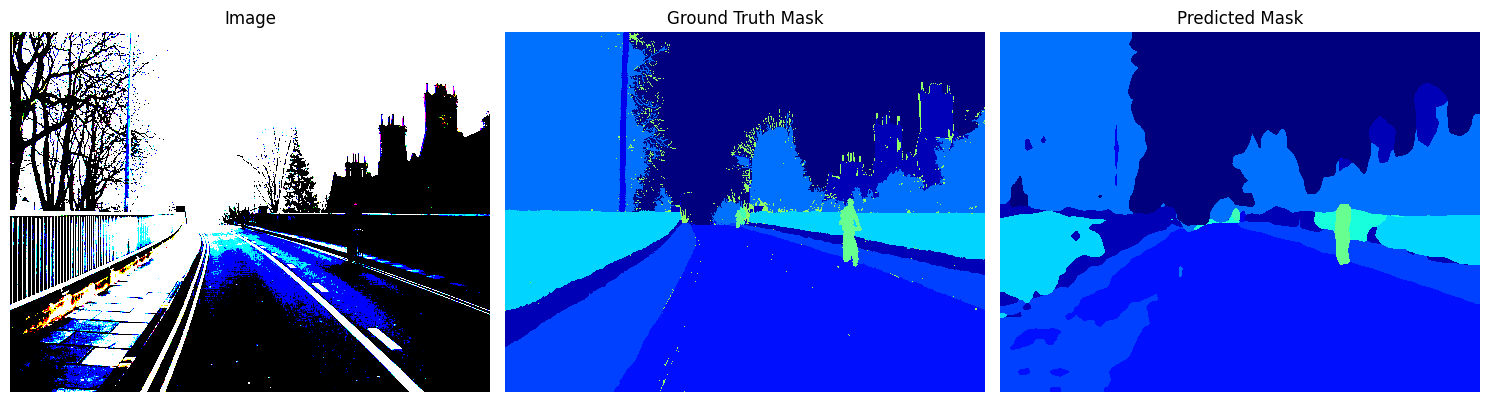

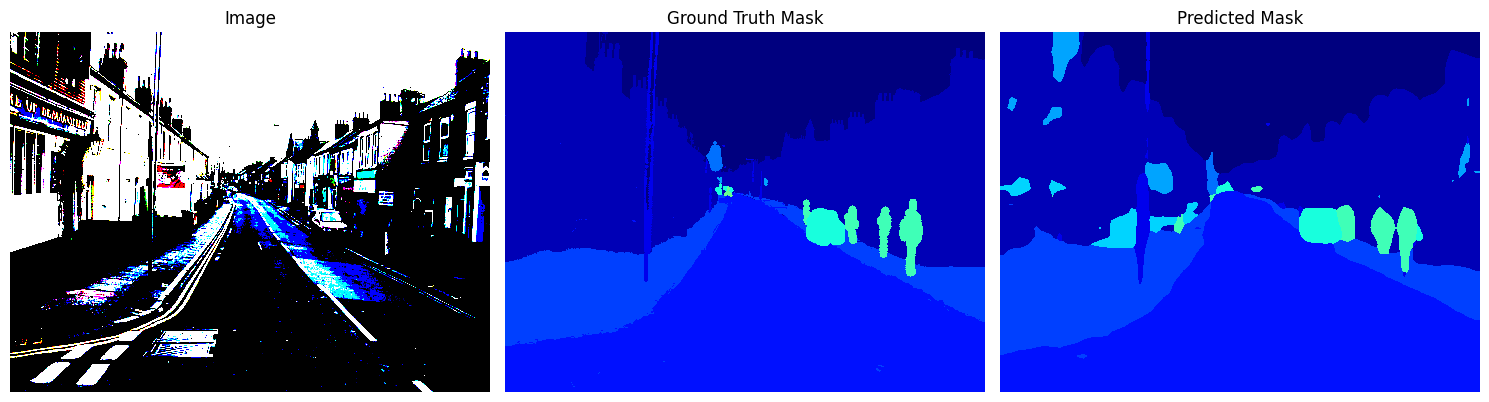

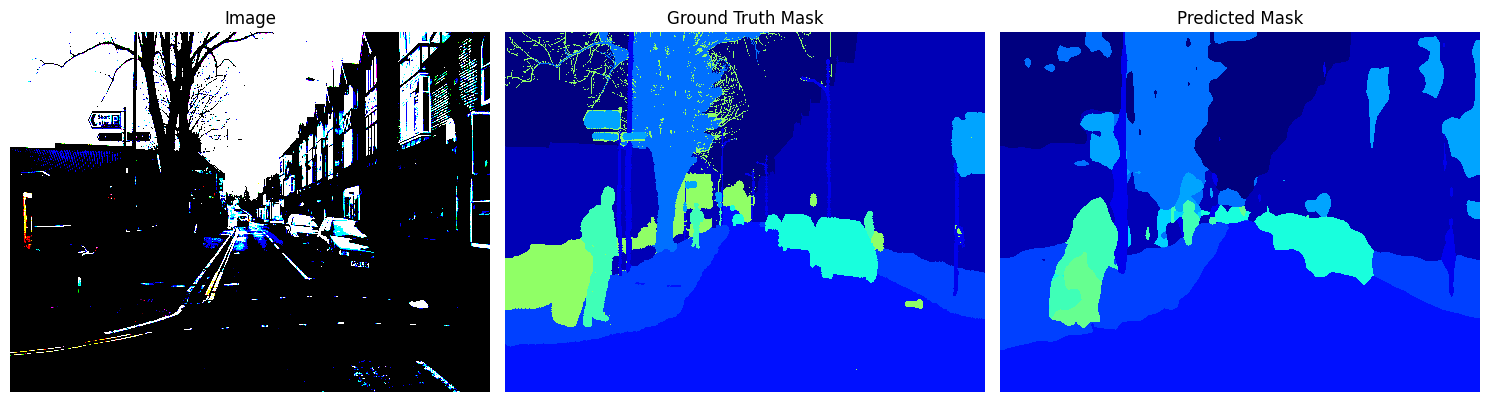

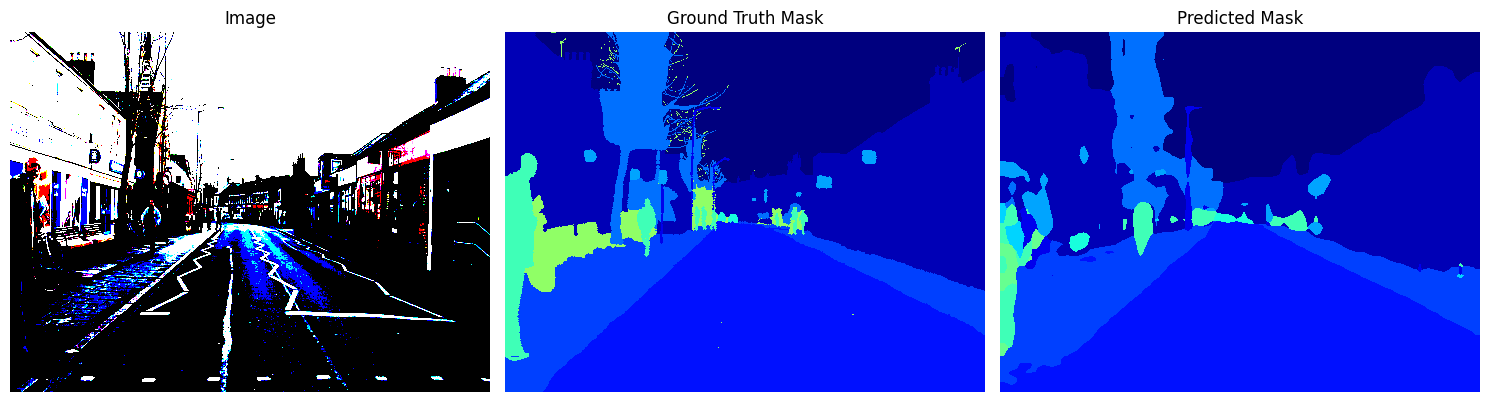

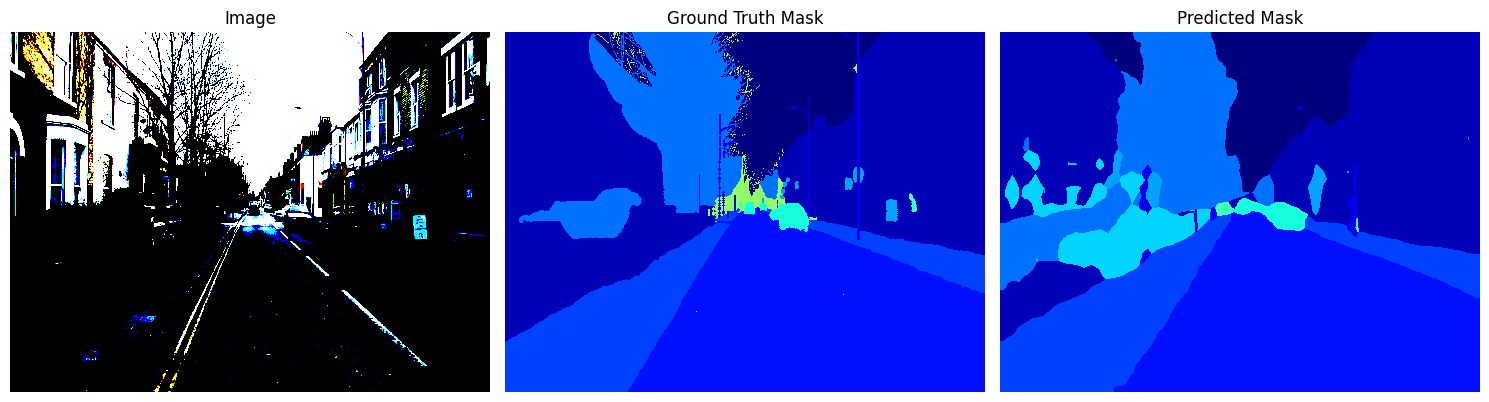

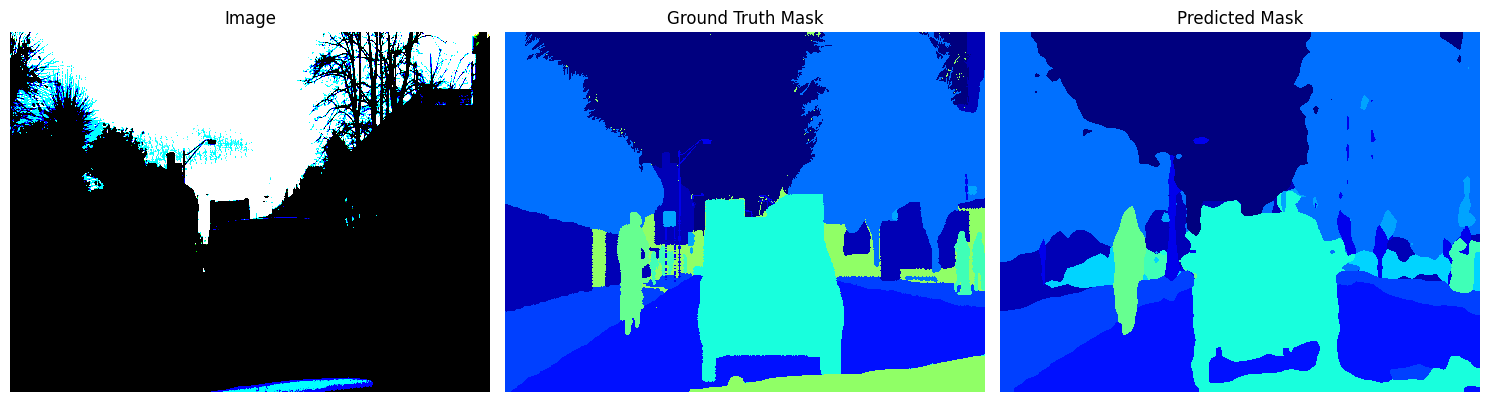

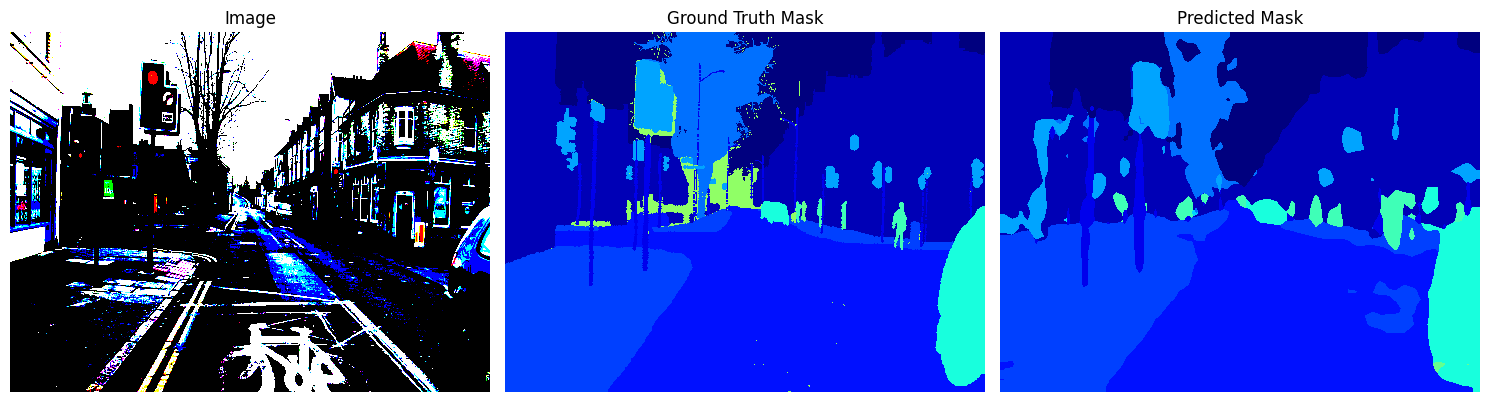

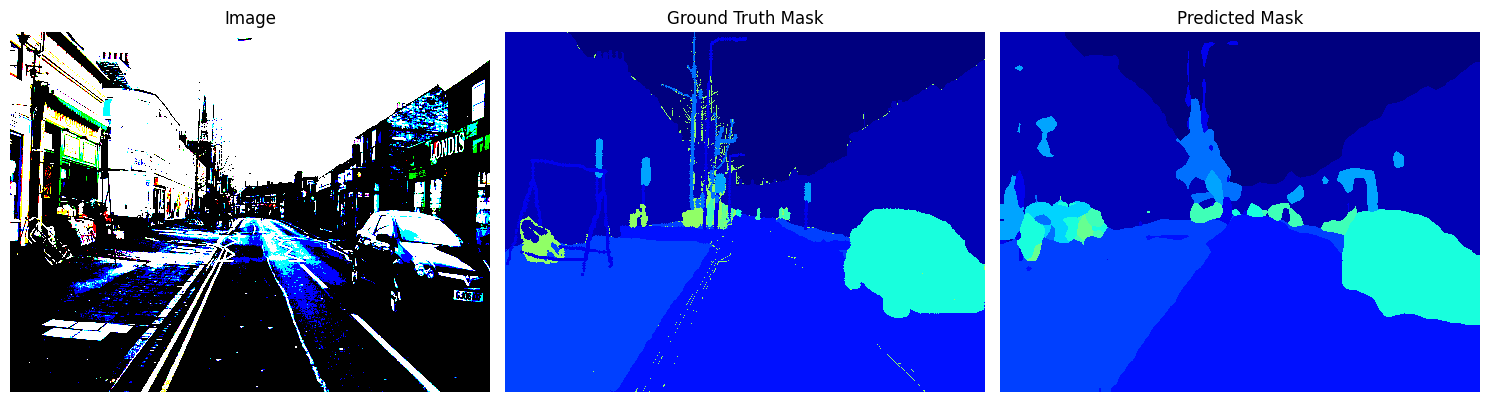

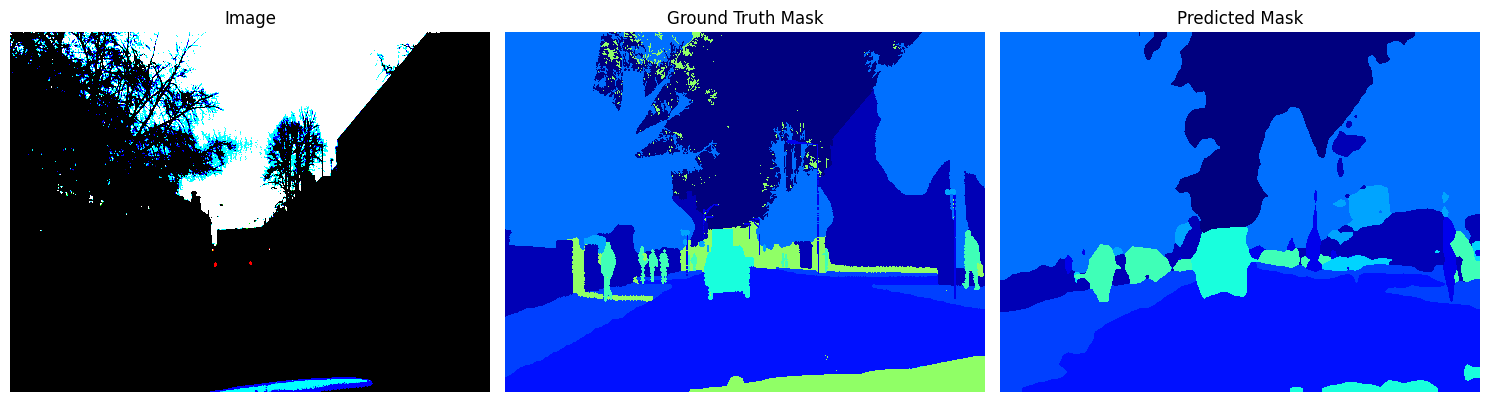

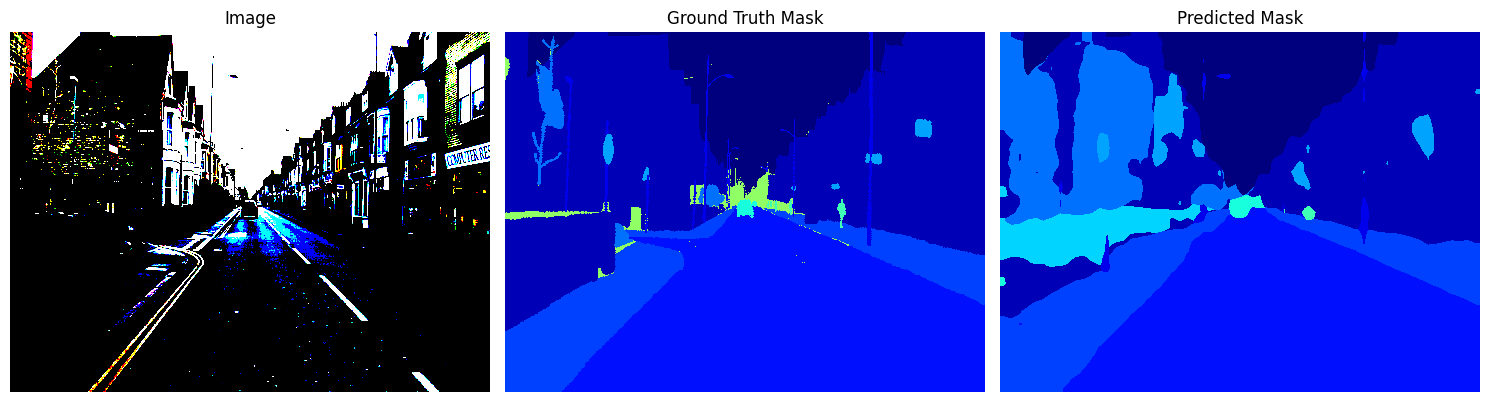

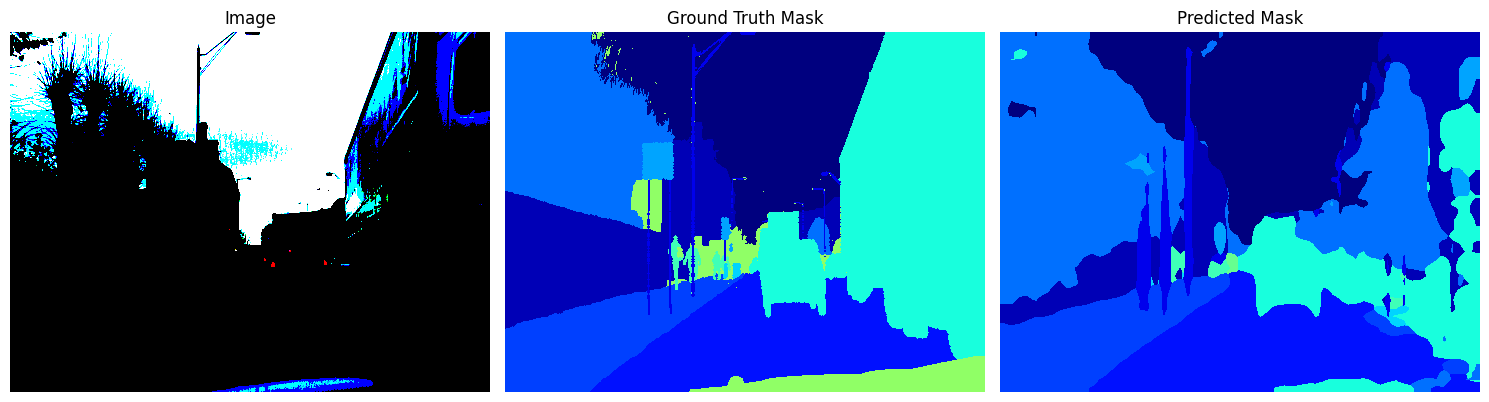

0.5713196403870169
[0.9010697791489021, 0.7104219723216966, 0.2232253698977553, 0.9222700836133355, 0.7578749951319366, 0.6662603132349716, 0.24797682022246348, 0.2543372429514193, 0.7711275573829725, 0.3824087496611628, 0.44754316069057104]


In [26]:
import sys

if __name__ == '__main__':
    parser = ArgumentParser()
#     parser = argparse.ArgumentParser()
    parser.add_argument('--model', type = str, default = "CGNet", help = "model name: Context Guided Network")
    parser.add_argument('--dataset', type = str, default = "camvid", help = "camvid or cityscapes")
    parser.add_argument('--ignore_label', type = int, default = 11, help = "nClass")
    parser.add_argument('--data_dir', default = "/kaggle/input/cgnet-camvid-output/CAMVID_data", help = "data directory")
    parser.add_argument('--test_data_list', default = "/kaggle/input/cgnet-camvid-output/CAMVID_data/camvid_test_list.txt", help= "data directory")
    parser.add_argument('--scaleIn', type = int, default = 1, help = "for input image, default is 1, keep fixed size")  
    parser.add_argument('--num_workers', type = int, default = 1, help = "the number of parallel threads") 
    parser.add_argument('--batch_size', type = int, default = 1, help = "the batch size is set to 1 when testing")
    parser.add_argument('--resume', type = str, default = '/kaggle/working/CGNet/checkpoint/camvid/CGNet_M3N9bs8gpu1_ontrainval/model_70.pth', 
                         help = "use this file to load last checkpoint for testing")
    parser.add_argument('--classes', type = int, default = 11, 
                         help = "the number of classes in the dataset. 19 and 11 for cityscapes and camvid, respectively")
    parser.add_argument('--inform_data_file', default = "/kaggle/input/cgnet-camvid-output/CGNet/camvid_inform.pkl", 
                         help = "storing classes weights, mean and std")
    parser.add_argument('--M', type = int, default = 3,  help = "the number of block in stage 2")
    parser.add_argument('--N', type = int, default = 9, help = "the number of block in stage 3")
    parser.add_argument('--cuda', type = bool, default = True, help = "running on CPU or GPU")
    parser.add_argument("--gpus", type = str, default = "0",  help = "gpu ids (default: 0)")
    parser.add_argument("--gpu_nums",  type = int, default=1 , help="the number of gpu")
    
#     args, unknown = parser.parse_known_args(sys.argv)
#     args = parser.parse_args()
    args, _ = parser.parse_known_args(sys.argv[1:])
    test_model(args)